# Team: KernelKnights

In [ ]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 967.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=e370e811133c8e838cf4d00b93c53c4ebacff27971eadbc2e2cdece18f1198d1
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def calculate_exponential_moving_average(df:pd.DataFrame, window:int = 5*4, column_name:str='close'):
    df_copy = df.copy()
    ema = df_copy[column_name].ewm(span=window, adjust=False).mean()
    df_copy[f'ema_{window}'] = ema
    return df_copy[['datetime',f'ema_{window}']]

#Function to calculate Moving Average Convergence Divergence Indicator
def calculate_moving_average_convergence_divergence(df: pd.DataFrame, slow_window: int = 16, fast_window: int = 8, signal_window: int = 4):
    df_copy = df.copy()
    exponential_moving_average_16 = calculate_exponential_moving_average(df_copy, slow_window)[f'ema_{slow_window}']
    exponential_moving_average_8 = calculate_exponential_moving_average(df_copy, fast_window)[f'ema_{fast_window}']
    macd = exponential_moving_average_8 - exponential_moving_average_16
    df_copy['macd'] = macd
    signal = calculate_exponential_moving_average(df_copy, signal_window, column_name='macd')[f'ema_{signal_window}']
    df_copy['signal_line'] = signal
    return df_copy[['datetime','macd']], df_copy[['datetime','signal_line']]

def calculate_weighted_moving_average(df: pd.DataFrame, window: int = 14*4):
    df_copy = df.copy()
    df_copy['wma'] = df_copy.ewm(alpha=1/window, adjust=False).mean()
    return df_copy['wma']

def calculate_average_true_range(df: pd.DataFrame, window: int = 14*4):
    df_copy = df.copy()
    high = df_copy['high']
    low = df_copy['low']
    close = df_copy['close']
    df_copy['arg_0'] = abs(high - low)
    df_copy['arg_1'] = abs(high - close.shift())
    df_copy['arg_2'] = abs(low - close.shift())
    args = df_copy[['arg_0', 'arg_1', 'arg_2']].max(axis=1)
    df_copy['average_true_range'] = calculate_weighted_moving_average(args, window)
    return df_copy[['datetime','average_true_range']]

def calculate_adx(df, window=14*4):
    # Calculate True Range (TR)
    df_copy = df.copy()
    df_copy['up'] = df_copy['high'] - df_copy['high'].shift()
    df_copy['down'] = df_copy['low'].shift() - df_copy['low']
    df_copy['plus_dm'] = np.where((df_copy['up']>df_copy['down']) & (df_copy['up']>0), df_copy['up'], 0)
    df_copy['minus_dm'] = np.where((df_copy['down']>df_copy['up']) & (df_copy['down']>0), df_copy['down'], 0)
    df_copy['plus_dm_avg'] = calculate_weighted_moving_average(df_copy['plus_dm'], window)
    df_copy['minus_dm_avg'] = calculate_weighted_moving_average(df_copy['minus_dm'], window)
    df_copy['atr'] = calculate_average_true_range(df_copy)['average_true_range']
    df_copy['plus_di'] = 100 * (df_copy['plus_dm_avg']/df_copy['atr'])
    df_copy['minus_di'] = 100 * (df_copy['minus_dm_avg']/df_copy['atr'])
    df_copy['adx'] = 100 * (abs(df_copy['plus_di'] - df_copy['minus_di'])/(df_copy['plus_di'] + df_copy['minus_di']))
    df_copy['datetime'] = df['datetime']
    return df_copy[['datetime','adx']]

def calculate_supertrend(data, period=10, multiplier=3):
    df = data.copy()
    df['TR'] = np.maximum.reduce([df['high'] - df['low'], abs(df['high'] - df['close'].shift(1)), abs(df['low'] - df['close'].shift(1))])
    df['ATR'] = df['TR'].rolling(window=period).mean()
    df['UB'] = df['high'] + df['ATR'] * multiplier
    df['LB'] = df['low'] - df['ATR'] * multiplier
    df['Trend'] = np.nan  # Initialize 'Trend' column with NaN

    for i in range(1, len(df)):
        if df['close'][i] > df['UB'][i - 1]:
            df.at[df.index[i], 'Trend'] = 1  # Bullish
        elif df['close'][i] < df['LB'][i - 1]:
            df.at[df.index[i], 'Trend'] = -1  # Bearish
        else:
            df.at[df.index[i], 'Trend'] = df['Trend'][i - 1]  # Maintain previous trend

    return df[['datetime','open', 'high', 'low', 'close', 'Trend']]

In [ ]:
def get_statscores(df):
  df_adx = calculate_adx(df)
  df_ema = calculate_exponential_moving_average(df)
  df_macd, _ = calculate_moving_average_convergence_divergence(df)
  df_atr = calculate_average_true_range(df)
  df_super = calculate_supertrend(df)
  df_adx.dropna(inplace=True)

  plt.figure(figsize=(12, 6))
  plt.plot(df_adx['datetime'].iloc[2900:3000], df_adx['adx'].iloc[2900:3000], label='ADX', color='blue')
  plt.plot(df_ema['datetime'].iloc[2900:3000], (df_ema[f'ema_{5*4}'].iloc[2900:3000]-7000)/50, label='EMA', color='green')
  plt.plot(df_macd['datetime'].iloc[2900:3000], df_macd['macd'].iloc[2900:3000]/10+10, label='MACD', color='black')
  plt.plot(df_atr['datetime'].iloc[2900:3000], df_atr['average_true_range'].iloc[2900:3000]/10, label='ATR', color='teal')
  # plt.figure(figsize=(12, 6))
  plt.plot(df['datetime'].iloc[2900:3000], (df['close'].iloc[2900:3000]-7000)/50, label='Close Prices', color='red')

  plt.title('Average Directional Index (ADX)')
  plt.xlabel('Timestamp')
  plt.legend()
  plt.grid(True)
  plt.show()

  return df_adx, df_ema, df_macd, df_atr, df_super

# Trading algo

Predicted:
1. Tomorrow's trend confidence

Statistical (till today):
1. 5 day EMA
2. 14day ADX
3. Supertrend (10,3)

In [32]:
def get_equity_scores(
    original_df, df_adx, df_ema, df_macd, df_atr, df_super,
    path_2nd_order = '/content/2nd_order_v0_95colonFull.npy',
    path_dates_of_2nd_order = '/content/2nd_orderdate_v0_95colonFull.npy' ,
    start_index_in_original_data=5661, end_index_in_original_data=5958):

  df = original_df
  start = start_index_in_original_data
  end = end_index_in_original_data

  array_data2 = np.load(path_2nd_order)
  array_data3 = np.load(path_dates_of_2nd_order, allow_pickle=True)


  df_pred_2d = pd.DataFrame(array_data2, columns=["Tomorrow_Trend_Power"])
  df_pred_2d_date = pd.DataFrame(array_data3, columns=["datetime"])
  df_pred_2d['datetime'] = df_pred_2d_date['datetime']


  df = df.iloc[start:end].copy().reset_index(drop=True)
  df_adx = df_adx.iloc[start-1:end-1].copy().reset_index(drop=True)
  df_ema = df_ema.iloc[start:end].copy().reset_index(drop=True)
  df_super = df_super.iloc[start:end].copy().reset_index(drop=True)


  initial_capital = 100000
  capital = capital_without_slippage = initial_capital

  position = 0  # 0: no position, 1: long, -1: short
  buy_signal = False
  sell_signal = False
  bitcoins_bought = 0
  bitcoins_borrowed = 0
  largest_win = 0
  largest_loss = 0

  # Lists to keep track of trading decisions
  buy_dates = []
  buy_end_dates = []
  short_dates = []
  short_end_dates = []
  holding_durations = []

  # Lists to keep track of equity curve
  equity_curve = []

  for i in range(0, len(df)-1):
      if df_adx['adx'][i] > 27 or df_pred_2d['Tomorrow_Trend_Power'][i+1] > 0.9 or df_pred_2d['Tomorrow_Trend_Power'][i+1] < -0.9:
          # Buy conditions
          if df_pred_2d['Tomorrow_Trend_Power'][i+1] > 0 and (df_ema[f'ema_{5*4}'][i] > df['close'][i] or df_super['Trend'][i] == 1) :
              buy_signal = True

          # Sell conditions
          if df_pred_2d['Tomorrow_Trend_Power'][i+1] < 0 or df_super['Trend'][i] == -1:
              sell_signal = True

          # Execute trading decisions
          if buy_signal and position == 0:
              position = 1  # Buy
              buy_price = df['close'][i]
              bitcoins_bought = capital / buy_price
              buy_dates.append(df['datetime'][i])

          elif sell_signal and position == 1:
              position = 0  # Sell
              sell_price = df['close'][i]
              price_diff = sell_price - buy_price
              capital += bitcoins_bought * price_diff * 0.995  # slippage/transaction
              capital_without_slippage += bitcoins_bought * price_diff
              buy_end_dates.append(df['datetime'][i])
              holding_duration = pd.to_datetime(df['datetime'][i]) - pd.to_datetime(buy_dates[-1])
              holding_durations.append(holding_duration.total_seconds() / 3600)  # Convert to hours

              if price_diff > 0:
                largest_win = max(largest_win, bitcoins_bought * price_diff)
              else:
                largest_loss = min(largest_loss, bitcoins_bought * price_diff)

          elif sell_signal and position == 0:
              position = -1  # short
              short_price = df['close'][i]
              bitcoins_borrowed = capital / short_price
              short_dates.append(df['datetime'][i])

          elif buy_signal and position == -1:
              position = 0
              short_end_price = df['close'][i]
              price_diff = short_price - short_end_price
              capital += bitcoins_borrowed * price_diff * 0.995  # slippage/transaction
              capital_without_slippage += bitcoins_borrowed * price_diff
              short_end_dates.append(df['datetime'][i])
              holding_duration = pd.to_datetime(df['datetime'][i]) - pd.to_datetime(short_dates[-1])
              holding_durations.append(holding_duration.total_seconds() / 3600)  # Convert to hours

              if price_diff > 0:
                largest_win = max(largest_win, bitcoins_bought * price_diff)
              else:
                largest_loss = min(largest_loss, bitcoins_bought * price_diff)

          buy_signal = False
          sell_signal = False

      # Calculate equity curve
      equity_curve.append(capital)

  return equity_curve, buy_dates, buy_end_dates, short_dates, short_dates, short_end_dates, holding_durations, largest_win, largest_loss, df

In [33]:
def calculate_perf_metrics(df,equity_curve,buy_dates, buy_end_dates, short_dates, short_end_dates,largest_win, largest_loss):
  initial_capital = equity_curve[0]
  capital = equity_curve[-1]

  tot_days = len(equity_curve)/4
  num_years = tot_days/365
  annualized_return = ((capital / initial_capital) ** (1 / num_years) - 1)

  tot_returns = (capital - initial_capital) / initial_capital

  equity_curve = pd.Series(equity_curve, index=df['datetime'][:-1])
  equity_curve.plot(figsize=(10, 6), title='Equity Curve')
  plt.show()

  returns = np.array(equity_curve[1:]) - np.array(equity_curve[:-1])
  _returns = np.array(equity_curve[4:]) - np.array(equity_curve[:-4])
  sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(4*tot_days)
  downside_returns = _returns[_returns<0]
  downside_std = np.std(downside_returns)
  excess_return = _returns.mean()
  sortino_ratio = (excess_return / downside_std) * np.sqrt(1 * tot_days)

  max_drawdown = ((equity_curve / equity_curve.cummax()) - 1).min()

  gross_prof = np.sum(returns[returns>0])
  net = capital-initial_capital
  no_trade = len(buy_dates)+len(buy_end_dates)+len(short_dates)+len(short_end_dates)
  max_drawdown = ((equity_curve / equity_curve.cummax()) - 1).min()
  win_rate = np.sum(returns>0)/no_trade*100
  loss_rate = np.sum(returns<0)/no_trade*100
  gross_loss = np.sum(returns[returns<0])
  avg_win_trade = np.sum(returns[returns>0]) / np.sum(returns>0)
  avg_loss_trade = np.sum(returns[returns<0]) / np.sum(returns<0)
  buy_and_hold_return = (df['close'].iloc[-1] - df['close'].iloc[0]) / df['close'].iloc[0] * 100
  average_holding_duration = np.mean(holding_durations)

  print(f"Actual returns: {tot_returns*100:.2f}")
  print(f"Sortino Ratio: {sortino_ratio:.2f}")
  print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
  print(f"Annualized Returns: {annualized_return:.2%}")

  print(f"Gross Profit: {gross_prof:.2f}")
  print(f"Net Profit: {net:.2f}")
  print(f"No of trades closed: {no_trade}")
  print(f"Win Rate: {win_rate:.2f}")
  print(f"Loss Rate: {loss_rate:.2f}")
  print(f"Maximum Drawdown: {max_drawdown:.2%}")
  print(f"Gross Loss: {gross_loss:.2f}")
  print(f"Avg winning trade: {avg_win_trade:.2f}")
  print(f"Avg losing trade: {avg_loss_trade:.2f}")
  print(f"Buy and Hold Return: {buy_and_hold_return:.2f}")
  print(f"Largest winning trade: {largest_win:.2f}")
  print(f"Largest losing trade: {largest_loss:.2f}")
  print(f"Average Holding Duration (hrs): {average_holding_duration:.2f}")

  return tot_returns*100, sharpe_ratio, annualized_return, max_drawdown

In [35]:
def visualize_buy_sell_signal(df,buy_dates, buy_end_dates, short_dates, short_end_dates):
  # Visualize buy/sell decision
  plt.figure(figsize=(12, 6))
  plt.plot(df['datetime'], df['close'], label='Close Price', color='grey')
  # plt.plot(df_adx['datetime'], df_adx['adx'], label='ADX', color='red')
  plt.scatter(buy_dates, df.loc[df['datetime'].isin(buy_dates)]['close'], marker='^', color='green', label='Buy/Long Signal')
  plt.scatter(buy_end_dates, df.loc[df['datetime'].isin(buy_end_dates)]['close'], marker='v', color='red', label='Long Exit Signal')
  plt.scatter(short_dates, df.loc[df['datetime'].isin(short_dates)]['close'], marker='<', color='blue', label='Short Signal')
  plt.scatter(short_end_dates, df.loc[df['datetime'].isin(short_end_dates)]['close'], marker='>', color='pink', label='Short exit Signal')
  plt.title('Trading Algorithm - Buy/Sell Signals')
  plt.xlabel('Timestamp')
  plt.ylabel('Close Price')
  plt.legend()
  plt.show()

# Inference

In [36]:
original_df = pd.read_csv('/content/drive/MyDrive/KDSH Data/btc_6h.csv')

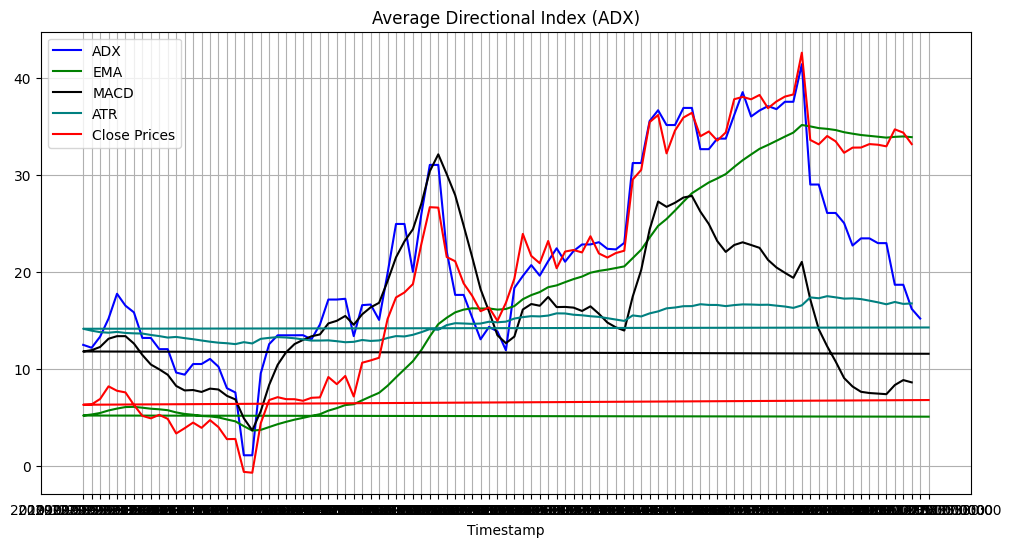

In [37]:
df_adx, df_ema, df_macd, df_atr, df_super = get_statscores(original_df)

In [38]:
equity_curve, buy_dates, buy_end_dates, short_dates, short_dates, short_end_dates, holding_durations,largest_win, largest_loss, trunc_df = get_equity_scores(
    original_df, df_adx, df_ema, df_macd, df_atr, df_super,
    path_2nd_order = '/content/drive/MyDrive/btc_king/8/2nd_order_v0_95colonFull.npy',
    path_dates_of_2nd_order = '/content/drive/MyDrive/btc_king/8/2nd_orderdate_v0_95colonFull.npy' ,
    start_index_in_original_data=5661, end_index_in_original_data=5958)

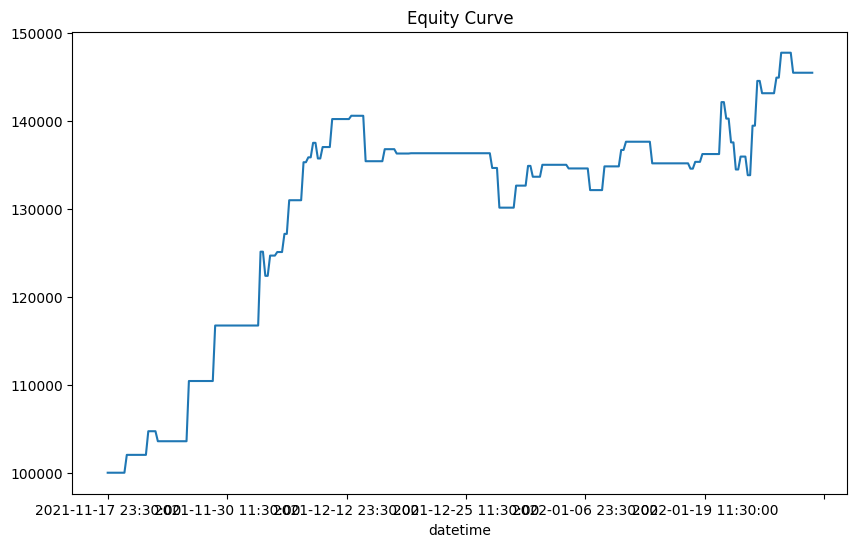

Actual returns: 45.47
Sortino Ratio: 3.06
Sharpe Ratio: 2.12
Annualized Returns: 535.14%
Gross Profit: 83602.33
Net Profit: 45469.88
No of trades closed: 101
Win Rate: 30.69
Loss Rate: 18.81
Maximum Drawdown: -7.43%
Gross Loss: -38132.44
Avg winning trade: 2696.85
Avg losing trade: -2006.97
Buy and Hold Return: -37.22
Largest winning trade: 8504.36
Largest losing trade: -5181.14
Average Holding Duration (hrs): 21.96


In [40]:
tot_returns_per, sharpe_ratio, annualized_return, max_drawdown = calculate_perf_metrics(trunc_df, equity_curve, buy_dates, buy_end_dates, short_dates, short_end_dates,largest_win, largest_loss)

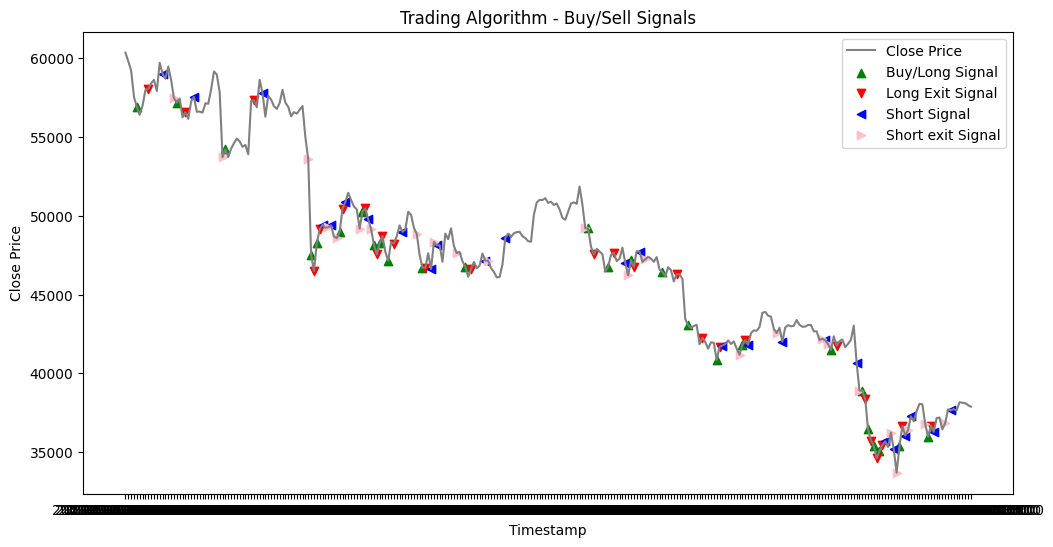

In [41]:
visualize_buy_sell_signal(trunc_df, buy_dates, buy_end_dates, short_dates, short_end_dates)